In [18]:
# Importing libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)
import datetime as dt
import missingno as msno
plt.rcParams['figure.dpi'] = 140

In [19]:
df = pd.read_csv('netflix_titles.csv')

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."


In [20]:
# Missing data

for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100 
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

director null rate: 30.68%
cast null rate: 9.22%
country null rate: 6.51%
date_added null rate: 0.13%
rating null rate: 0.09%


5 columns have missing values, with Director missing 1/3 of the time

## Dealing with the missing data

- replace blank countries with the mode (most common) country

In [21]:
# Replacments

df['country'] = df['country'].fillna(df['country'].mode()[0])


df['cast'].replace(np.nan, 'No Data',inplace  = True)
df['director'].replace(np.nan, 'No Data',inplace  = True)

# Drops

df.dropna(inplace=True)

# Drop Duplicates

df.drop_duplicates(inplace= True)
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7770 non-null   object
 1   type          7770 non-null   object
 2   title         7770 non-null   object
 3   director      7770 non-null   object
 4   cast          7770 non-null   object
 5   country       7770 non-null   object
 6   date_added    7770 non-null   object
 7   release_year  7770 non-null   int64 
 8   rating        7770 non-null   object
 9   duration      7770 non-null   object
 10  listed_in     7770 non-null   object
 11  description   7770 non-null   object
dtypes: int64(1), object(11)
memory usage: 789.1+ KB


## Changing to date format

In [23]:
# Strip leading and trailing whitespace
df['date_added'] = df['date_added'].str.strip()

# Parse the dates with the specified format
df['date_added'] = pd.to_datetime(df['date_added'], format="%B %d, %Y")

# Extract month, month name, and year
df['month_added'] = df['date_added'].dt.month
df['month_name_added'] = df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

# Verify the result
df.head(3)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added
0,s1,TV Show,3%,No Data,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,8,August,2020
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,12,December,2016
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",12,December,2018


## Visualization

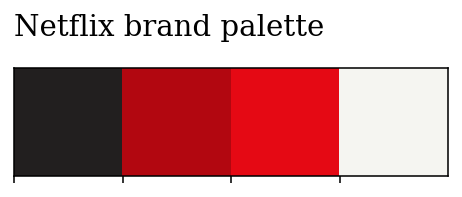

In [24]:
# Palette
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

In [26]:
#For viz: Ratio of Movies & TV shows

x=df.groupby(['type'])['type'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

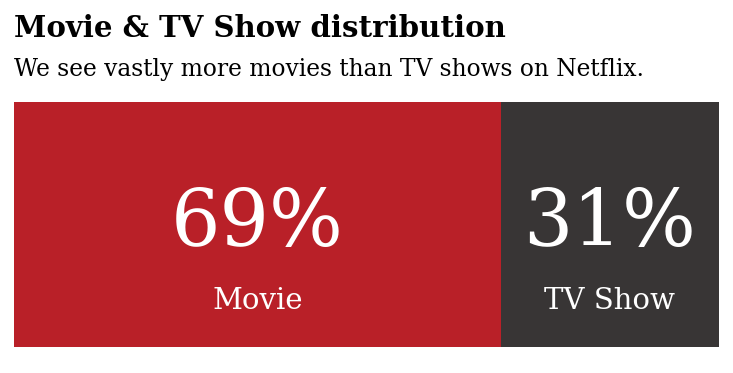

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Movie'], 
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], 
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')


# Title & Subtitle
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

In [28]:
df['count'] = 1
# Lets retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['first_country'].head()

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Reducing name length

df['first_country'].replace('United States', 'USA', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)

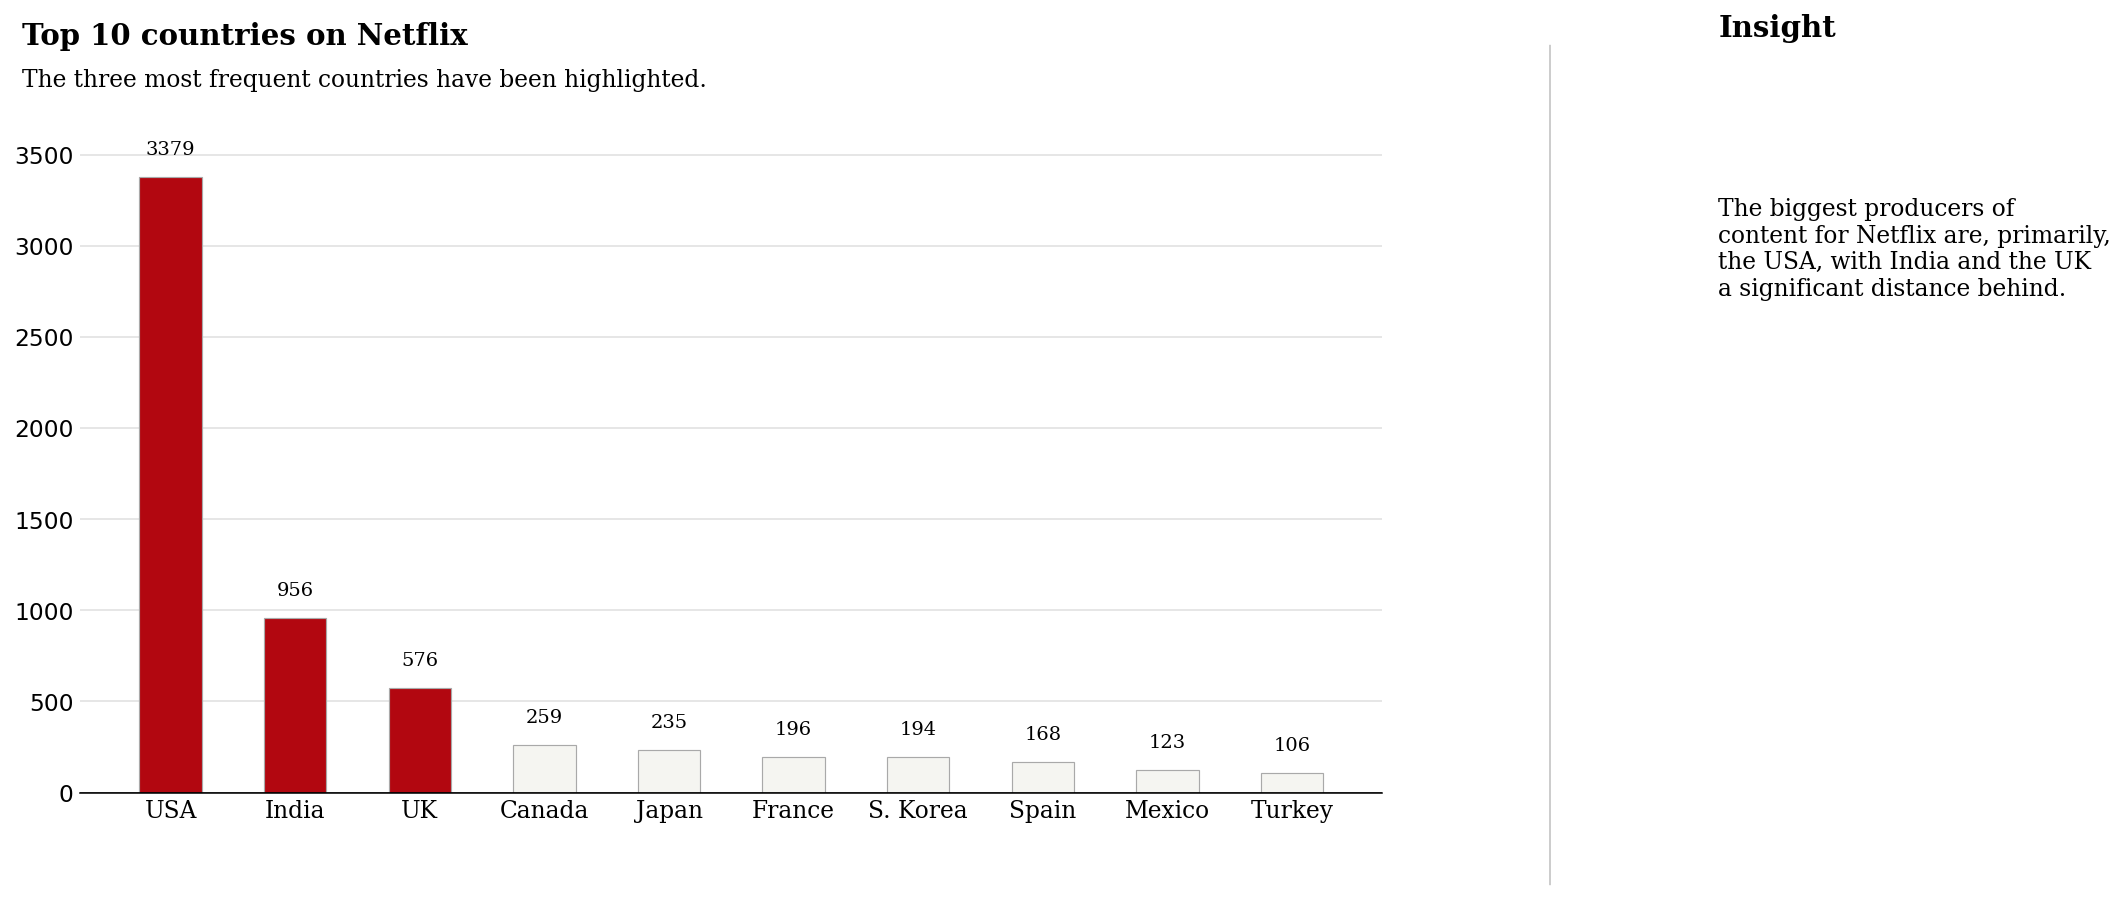

In [29]:
data = df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

# Plot

color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#b20710' # color highlight

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')



# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels

ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, 'Top 10 countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent countries have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.67, '''
The biggest producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)


import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

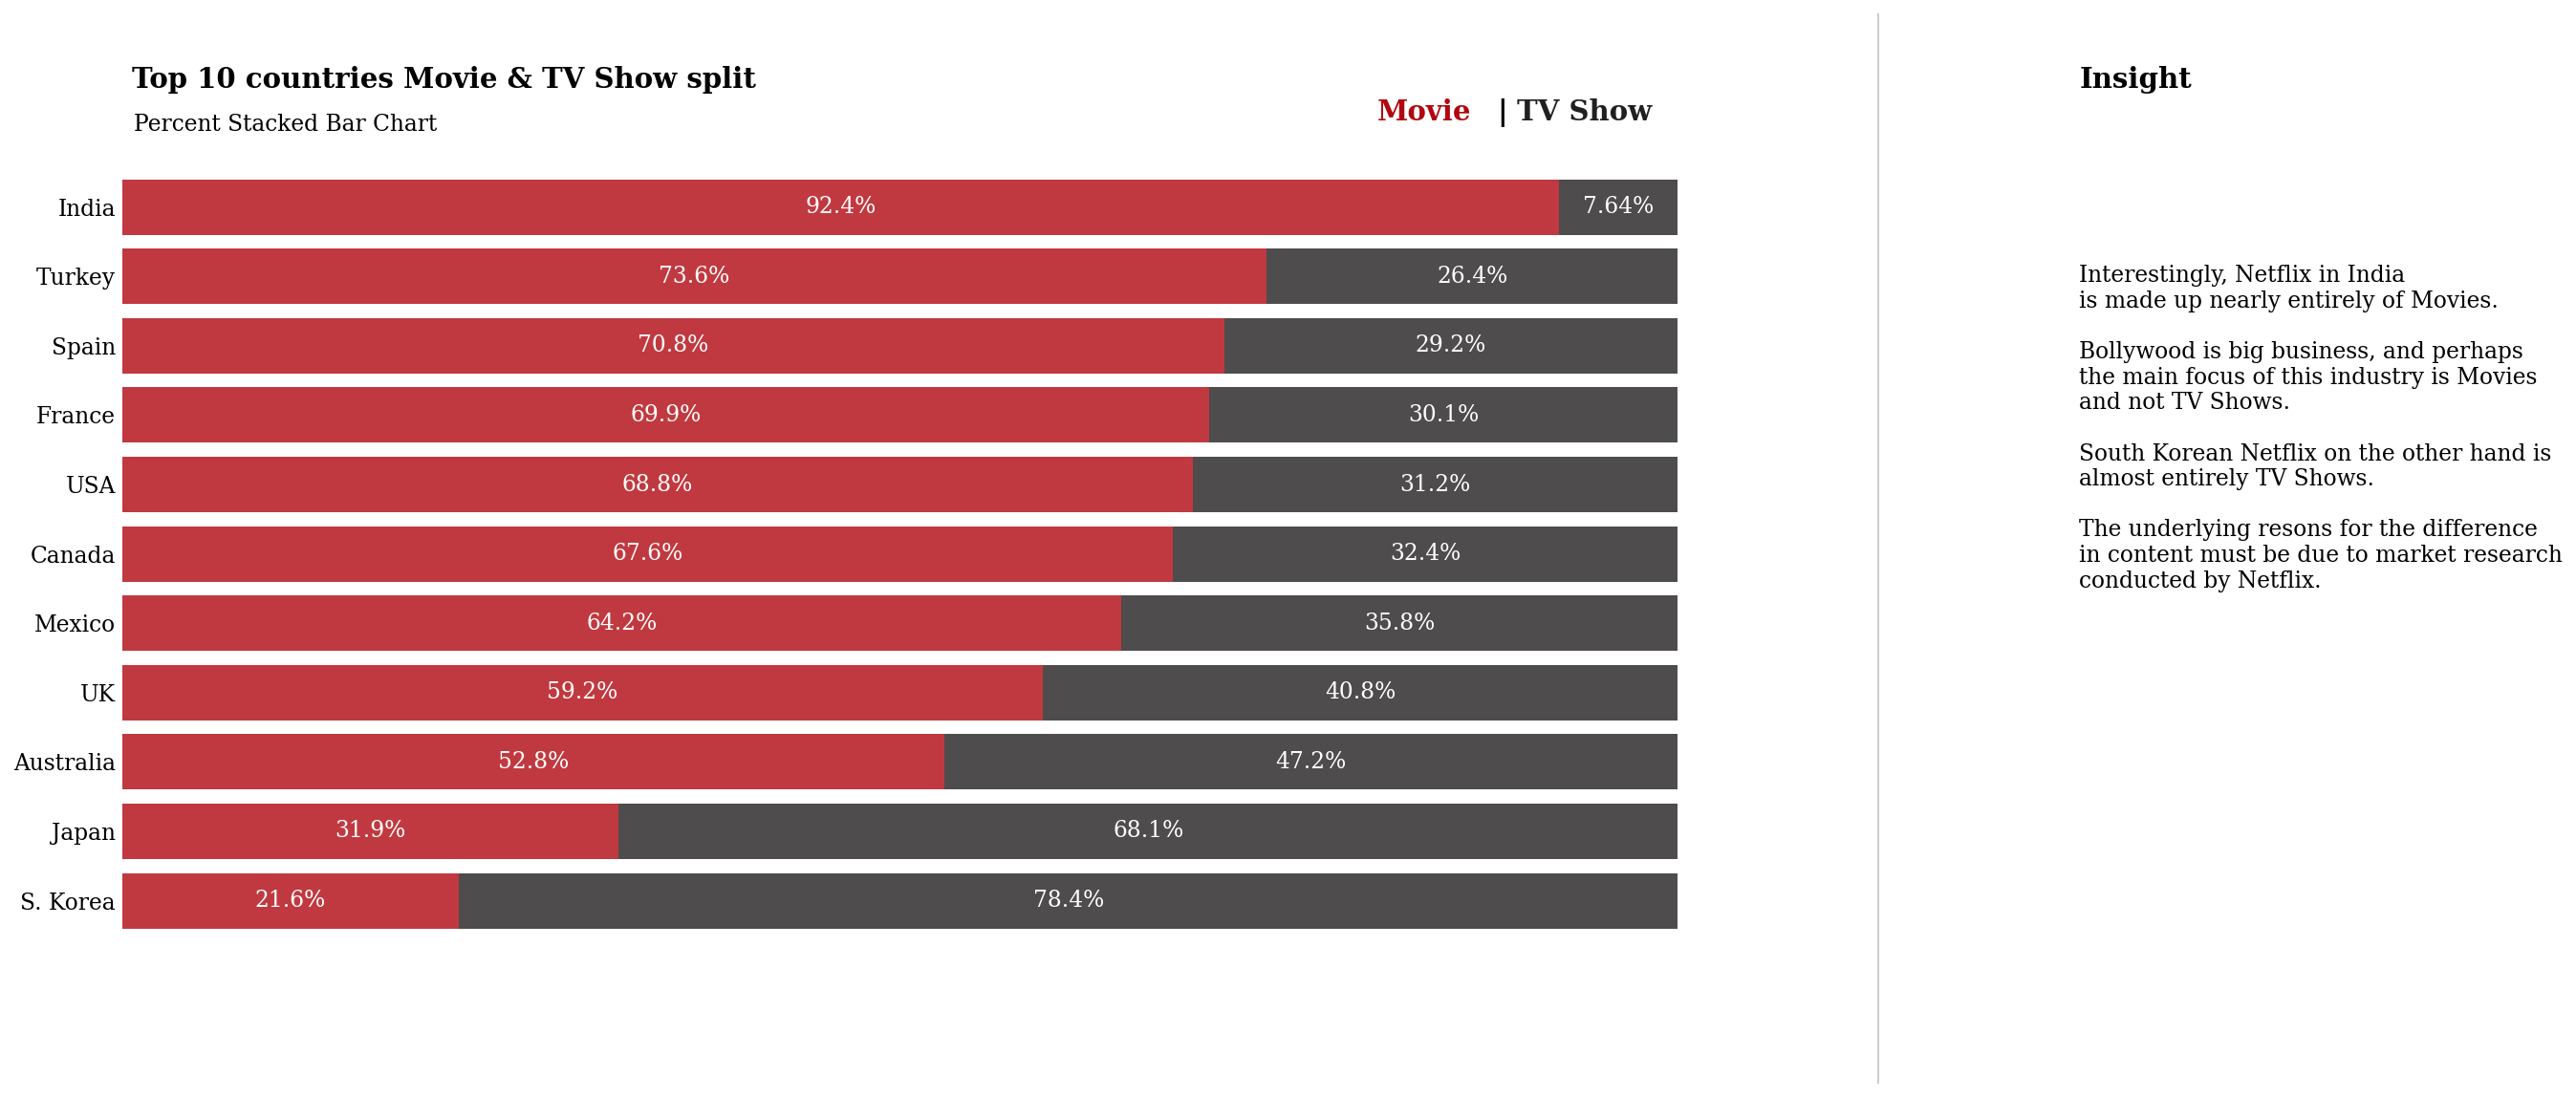

In [30]:
country_order = df['first_country'].value_counts()[:11].index
data_q2q3 = df[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]




###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


fig.text(1.1, 0.93, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.44, '''
Interestingly, Netflix in India
is made up nearly entirely of Movies. 

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korean Netflix on the other hand is 
almost entirely TV Shows.

The underlying resons for the difference 
in content must be due to market research
conducted by Netflix.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')



import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [31]:
order = pd.DataFrame(df.groupby('rating')['count'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])

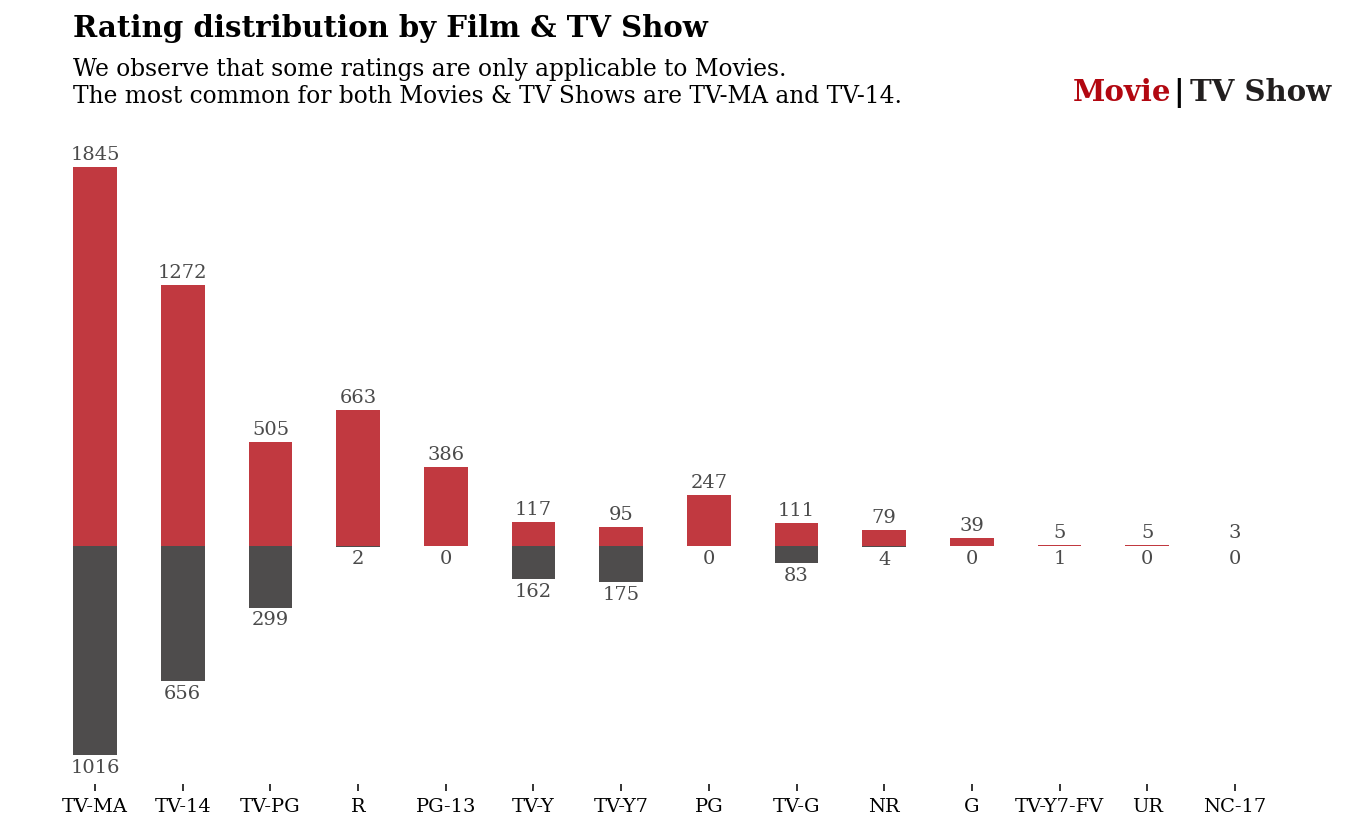

In [32]:
mf = df.groupby('type')['rating'].value_counts().unstack().sort_index().fillna(0).astype(int)[rating_order]

movie = mf.loc['Movie']
tv = - mf.loc['TV Show']


fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(movie.index, movie, width=0.5, color='#b20710', alpha=0.8, label='Movie')
ax.bar(tv.index, tv, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')
#ax.set_ylim(-35, 50)

# Annotations
for i in tv.index:
    ax.annotate(f"{-tv[i]}", 
                   xy=(i, tv[i] - 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in movie.index:
    ax.annotate(f"{movie[i]}", 
                   xy=(i, movie[i] + 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
 

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.89, 
'''We observe that some ratings are only applicable to Movies. 
The most common for both Movies & TV Shows are TV-MA and TV-14.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.755,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

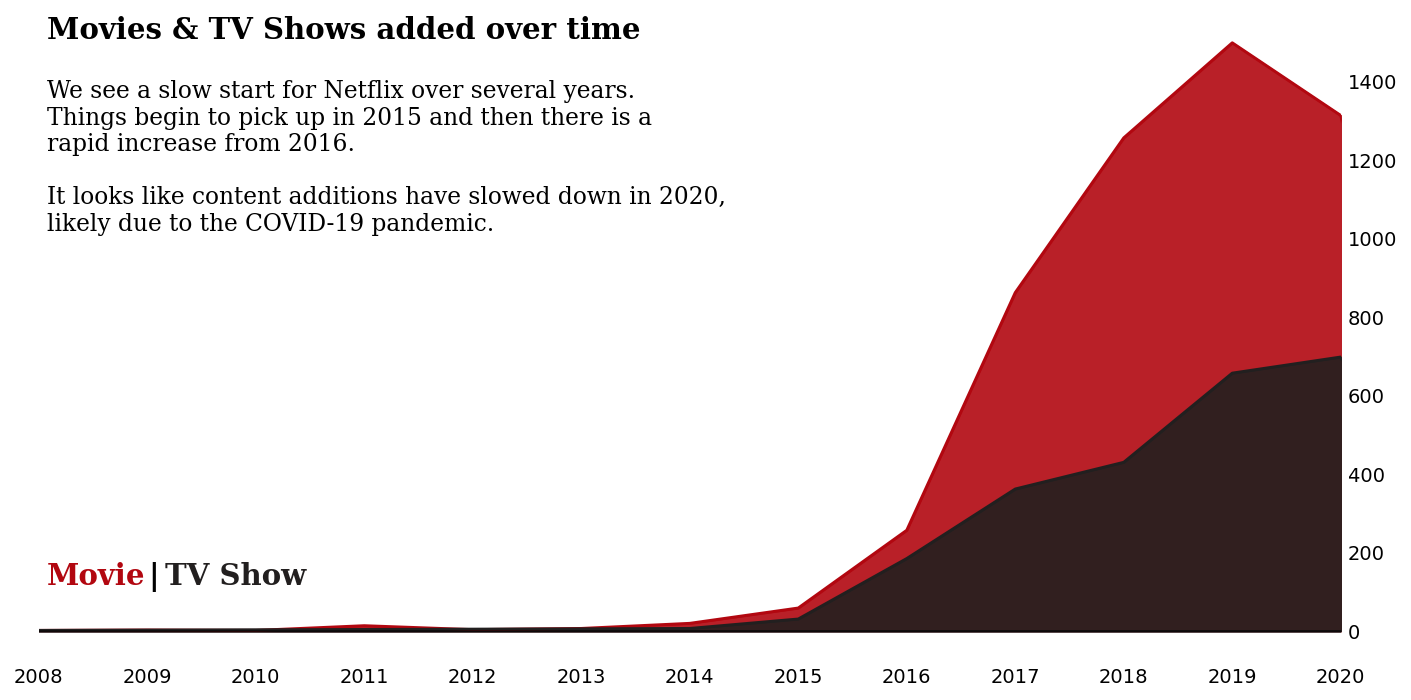

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = df[df['type']==mtv]['year_added'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv)
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9)
    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.59, 
'''We see a slow start for Netflix over several years. 
Things begin to pick up in 2015 and then there is a 
rapid increase from 2016.

It looks like content additions have slowed down in 2020, 
likely due to the COVID-19 pandemic.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [34]:
month_order = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

df['month_name_added'] = pd.Categorical(df['month_name_added'], categories=month_order, ordered=True)

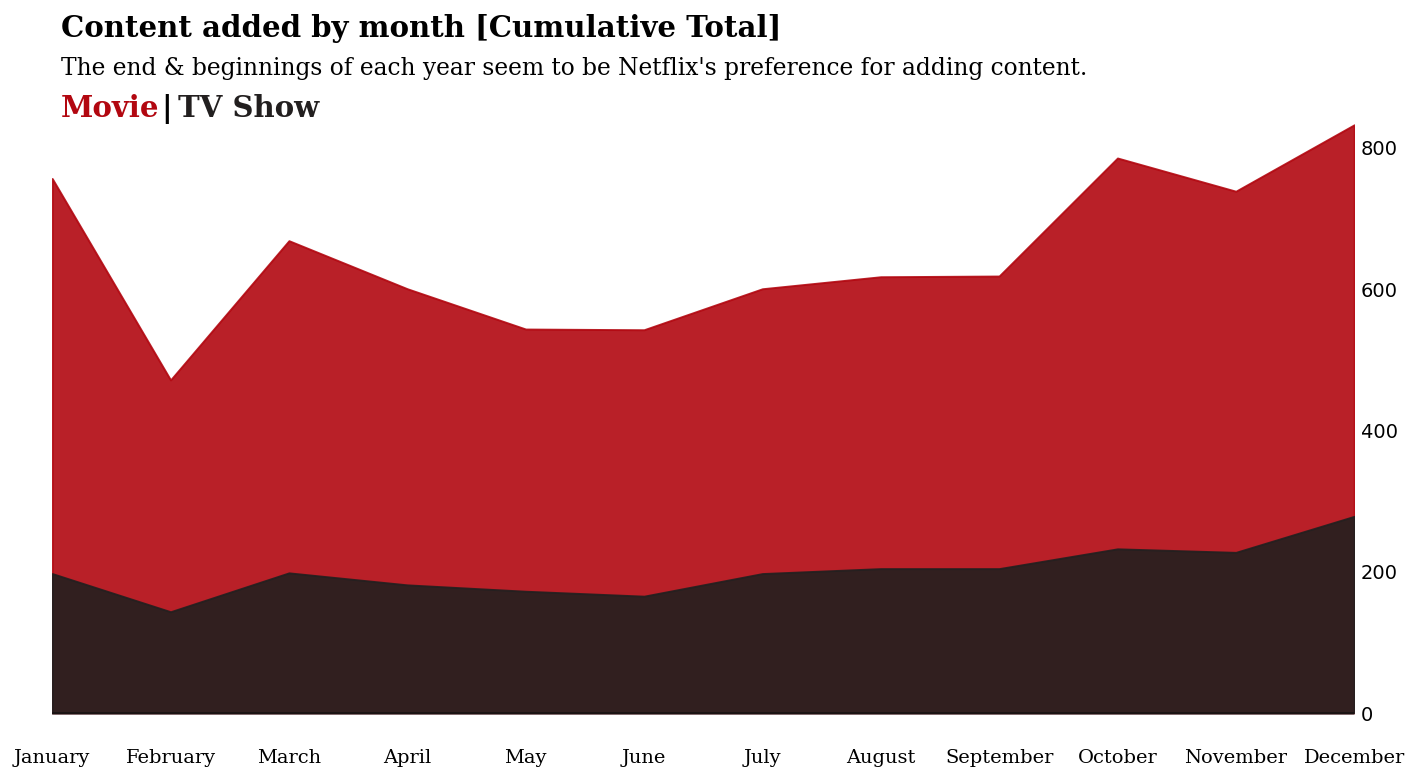

In [35]:
data_sub = df.groupby('type')['month_name_added'].value_counts().unstack().fillna(0).loc[['TV Show','Movie']].cumsum(axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv,alpha=0.9)
    

    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .4)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)
ax.set_xticklabels(data_sub.index, fontfamily='serif', rotation=0)
ax.margins(x=0) # remove white spaces next to margins

#ax.set_xlim(2008,2020)
#plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.95, 'Content added by month [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.905, 
"The end & beginnings of each year seem to be Netflix's preference for adding content."

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.13,0.855,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.855,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.855,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

### A more interesting way to view how content is added across the year

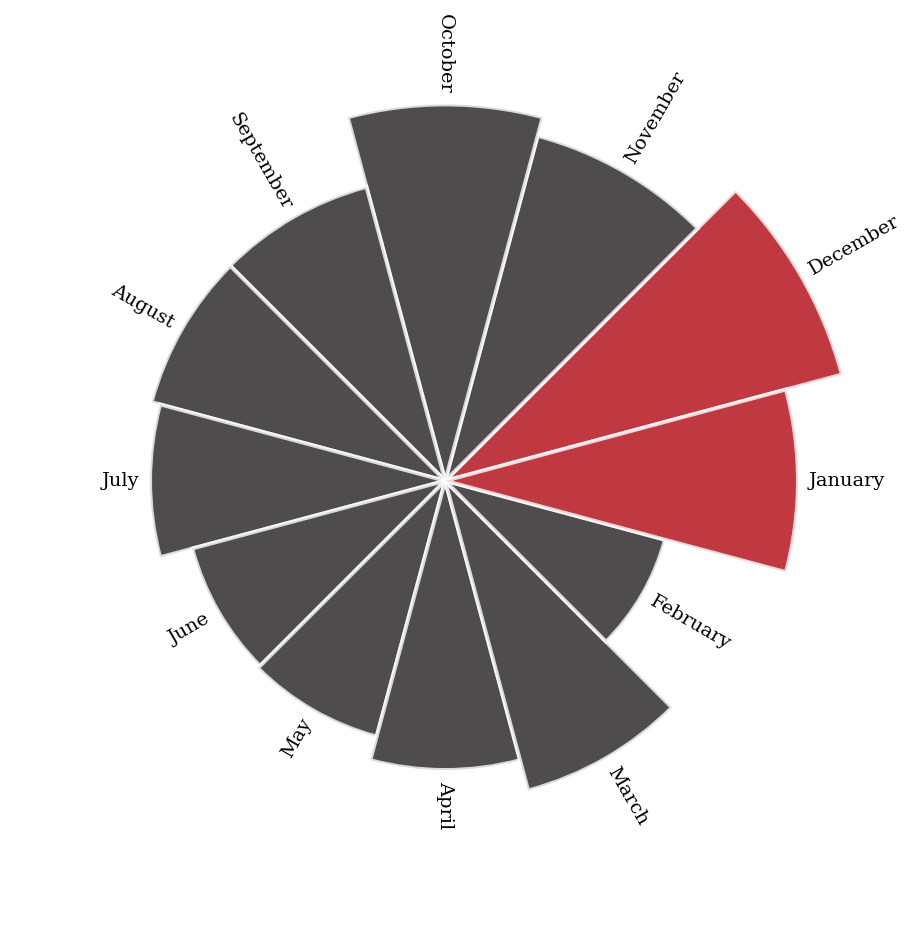

In [36]:
data_sub2 = data_sub

data_sub2['Value'] = data_sub2['Movie'] + data_sub2['TV Show']
data_sub2 = data_sub2.reset_index()

df_polar = data_sub2.sort_values(by='month_name_added',ascending=False)


color_map = ['#221f1f' for _ in range(12)]
color_map[0] = color_map[11] =  '#b20710' # color highlight


# initialize the figure
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 30
lowerLimit = 1
labelPadding = 30

# Compute max and min in the dataset
max = df_polar['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_polar.Value + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_polar.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_polar.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=color_map,alpha=0.8
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_polar["month_name_added"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, fontsize=10,fontfamily='serif',
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")